In [1]:
# %load wgan.py
import argparse
import os
import numpy as np
import math
import sys

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch

In [2]:
os.makedirs("images", exist_ok=True)

In [2]:
n_epochs = 200
batch_size = 64
lr = 0.00005
n_cpu = 8
latent_dim = 100
img_size = 28
channels = 1
n_critic = 5
clip_value = 0.01
sample_interval = 400

In [3]:
img_shape = (channels, img_size, img_size)

cuda = True if torch.cuda.is_available() else False


class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.shape[0], *img_shape)
        return img


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
        )

    def forward(self, img):
        img_flat = img.view(img.shape[0], -1)
        validity = self.model(img_flat)
        return validity


# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

if cuda:
    generator.cuda()
    discriminator.cuda()

# Configure data loader
os.makedirs("../../data/mnist", exist_ok=True)
dataloader = torch.utils.data.DataLoader(
    datasets.MNIST(
        "../../data/mnist",
        train=True,
        download=True,
        transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]),
    ),
    batch_size=batch_size,
    shuffle=True,
)

# Optimizers
optimizer_G = torch.optim.RMSprop(generator.parameters(), lr=lr)
optimizer_D = torch.optim.RMSprop(discriminator.parameters(), lr=lr)

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

In [5]:
# ----------
#  Training
# ----------
from IPython.display import clear_output

G_loss_history = []
D_loss_history = []

batches_done = 0
for epoch in range(n_epochs):
    G_batch_loss = 0
    D_batch_loss = 0
    for i, (imgs, _) in enumerate(dataloader):

        # Configure input
        real_imgs = Variable(imgs.type(Tensor))

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Sample noise as generator input
        z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], latent_dim))))

        # Generate a batch of images
        fake_imgs = generator(z).detach()
        # Adversarial loss
        loss_D = -torch.mean(discriminator(real_imgs)) + torch.mean(discriminator(fake_imgs))

        loss_D.backward()
        optimizer_D.step()
        
        D_batch_loss += loss_D.item()

        # Clip weights of discriminator
        for p in discriminator.parameters():
            p.data.clamp_(-clip_value, clip_value)

        # Train the generator every n_critic iterations
        if i % n_critic == 0:

            # -----------------
            #  Train Generator
            # -----------------

            optimizer_G.zero_grad()

            # Generate a batch of images
            gen_imgs = generator(z)
            # Adversarial loss
            loss_G = -torch.mean(discriminator(gen_imgs))

            loss_G.backward()
            optimizer_G.step()
            
            G_batch_loss += loss_G.item()

            print(
                "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
                % (epoch, n_epochs, batches_done % len(dataloader), len(dataloader), loss_D.item(), loss_G.item())
            )

        if batches_done % sample_interval == 0:
            save_image(gen_imgs.data[:25], "images/%d.png" % batches_done, nrow=5, normalize=True)
        batches_done += 1
    n = len(dataloader) / n_critic
    G_loss_history.append(G_batch_loss / n)
    D_loss_history.append(D_batch_loss / len(dataloader))
    if epoch % 10 == 0:
        clear_output()

[Epoch 191/200] [Batch 0/938] [D loss: -0.052451] [G loss: -0.416710]
[Epoch 191/200] [Batch 5/938] [D loss: -0.078255] [G loss: -0.434724]
[Epoch 191/200] [Batch 10/938] [D loss: -0.043104] [G loss: -0.435406]
[Epoch 191/200] [Batch 15/938] [D loss: -0.064378] [G loss: -0.408913]
[Epoch 191/200] [Batch 20/938] [D loss: -0.066051] [G loss: -0.424727]
[Epoch 191/200] [Batch 25/938] [D loss: -0.043348] [G loss: -0.448950]
[Epoch 191/200] [Batch 30/938] [D loss: -0.079830] [G loss: -0.440609]
[Epoch 191/200] [Batch 35/938] [D loss: -0.056138] [G loss: -0.474054]
[Epoch 191/200] [Batch 40/938] [D loss: -0.053541] [G loss: -0.454893]
[Epoch 191/200] [Batch 45/938] [D loss: -0.061531] [G loss: -0.412541]
[Epoch 191/200] [Batch 50/938] [D loss: -0.057294] [G loss: -0.374415]
[Epoch 191/200] [Batch 55/938] [D loss: -0.091597] [G loss: -0.392212]
[Epoch 191/200] [Batch 60/938] [D loss: -0.081582] [G loss: -0.413573]
[Epoch 191/200] [Batch 65/938] [D loss: -0.082443] [G loss: -0.390789]
[Epoch 1

In [4]:
generator.load_state_dict(torch.load('wgan_generator.pt'))

<All keys matched successfully>

In [6]:
pic_num = 64
latent_space = np.random.normal(0, 1, (pic_num, latent_dim))

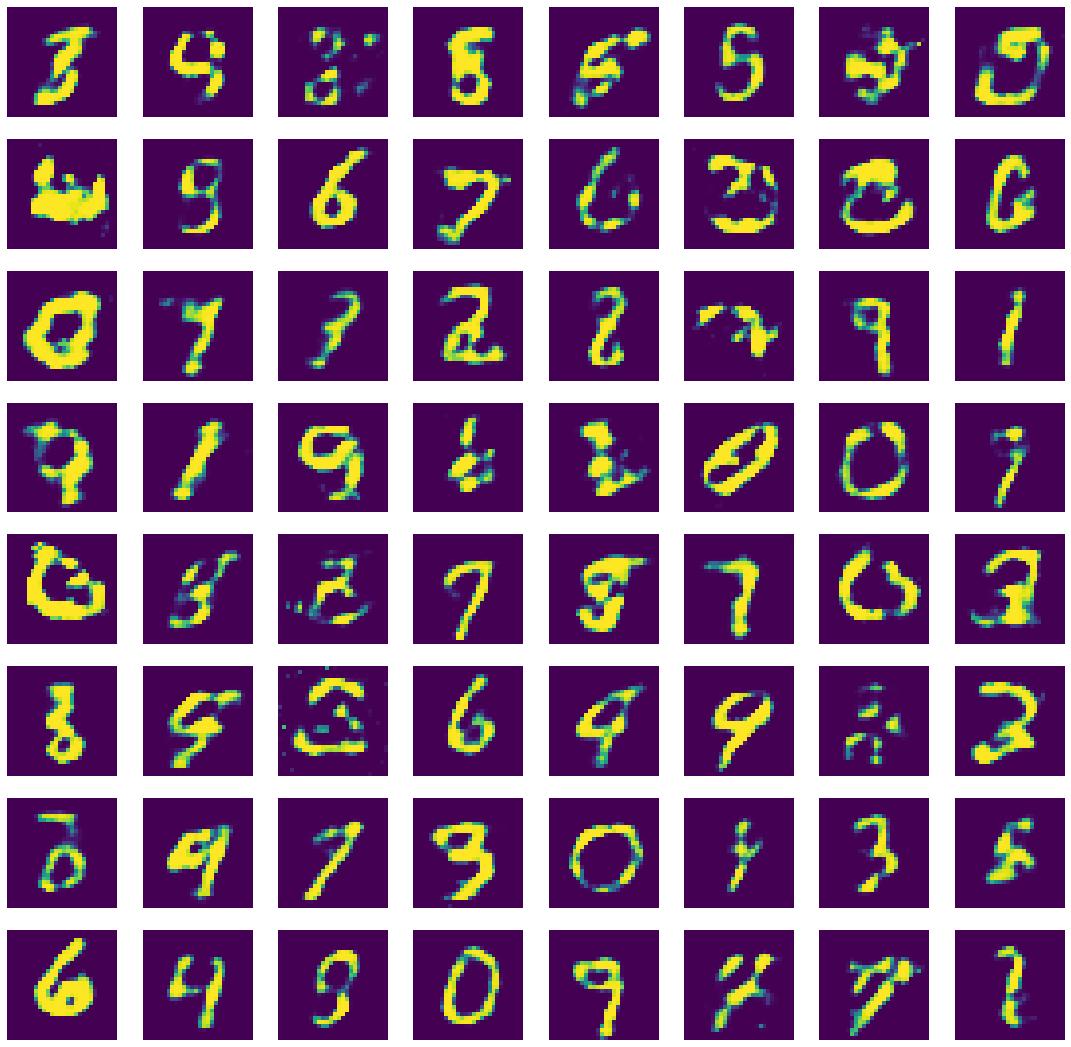

In [7]:
import matplotlib.pyplot as plt
plt.figure(figsize=(19, 19))
for i in range(pic_num):
    plt.subplot(8,8,i+1)
    plt.imshow(generator(Variable(Tensor(latent_space))).detach().view(pic_num, 28, 28, 1)[i].to('cpu'))
    plt.axis('off')

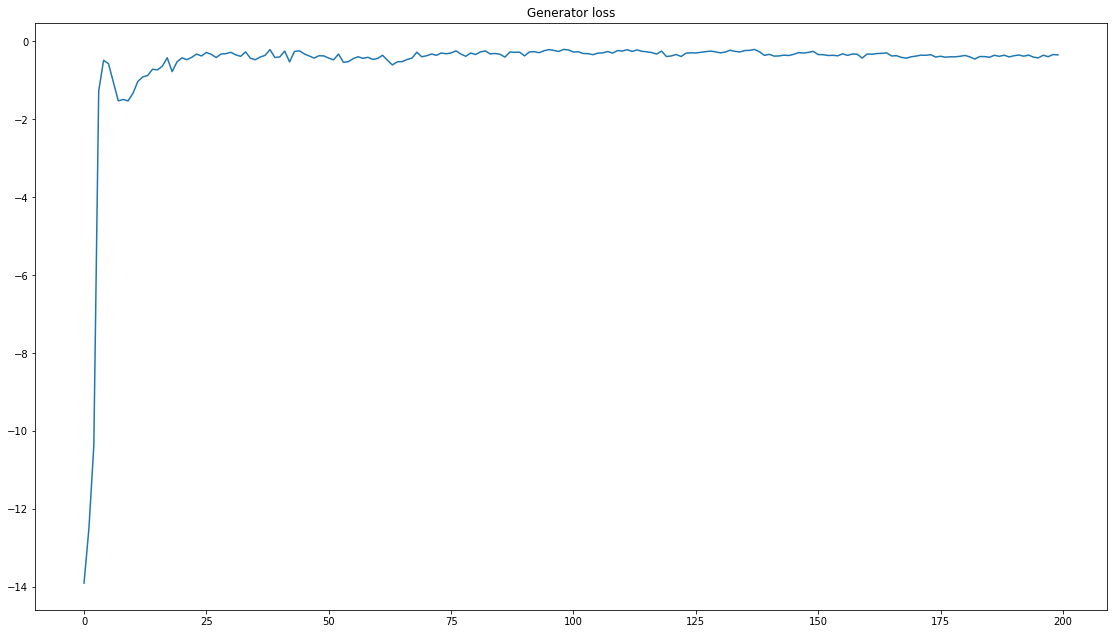

In [8]:
plt.figure(figsize=(19.2, 10.8))
plt.title('Generator loss')
x = np.arange(len(G_loss_history))
plt.plot(x, G_loss_history)

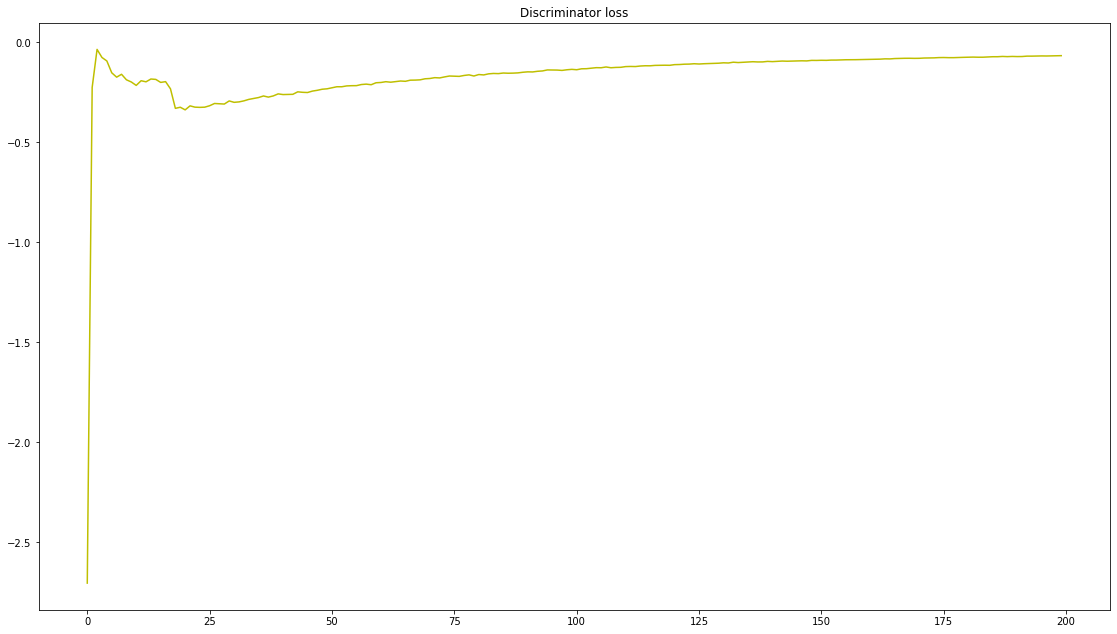

In [9]:
plt.figure(figsize=(19.2, 10.8))
plt.title('Discriminator loss')
x = np.arange(len(D_loss_history))
plt.plot(x, D_loss_history, 'y')

In [10]:
torch.save(generator.state_dict(),'wgan_generator.pt')
torch.save(discriminator.state_dict(), 'wgan_discriminator.pt')